In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(5336)

In [52]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
391
79
79


# Pre-activation CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [3]:
# from keras.layers import Layer
# import tensorflow as tf

# class CustomBatchNorm(Layer):
#     def __init__(self):
#         super(CustomBatchNorm, self).__init__()

#     def build(self, input_shape):
#         self.beta = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer="zeros",
#             trainable=True,
#         )

#         self.gamma = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer="ones",
#             trainable=True,
#         )

#         self.moving_mean = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer=tf.initializers.zeros,
#             trainable=False)

#         self.moving_variance = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer=tf.initializers.ones,
#             trainable=False)

#     def get_moving_average(self, statistic, new_value):
#         momentum = 0.9
#         new_value = statistic * momentum + new_value * (1 - momentum)
#         return statistic.assign(new_value)

#     def normalise(self, x, x_mean, x_var):
#         return (x - x_mean) / tf.sqrt(x_var + 1e-6)

#     def call(self, inputs, training):
#         if training:
#             axes = list(range(len(inputs.shape) - 1))
#             batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
#             batch_variance = tf.reduce_mean(tf.math.squared_difference(inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
#             mean = tf.squeeze(batch_mean, axes)
#             var = tf.squeeze(batch_variance, axes)
#             self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
#             self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
#         else:
#             mean, var = self.moving_mean, self.moving_variance

#         x = self.normalise(inputs, mean, var)
#         return self.gamma * x + self.beta

In [53]:
from keras.layers import Layer
import tensorflow as tf

class CustomBatchNorm(Layer):
    def __init__(self):
        super(CustomBatchNorm, self).__init__()

        self.eps=1e-5

    def build(self, input_shape):
        self.beta = self.add_weight(
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False)

        self.moving_variance = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False)

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            # assert len(inputs.shape) in (2, 4)
            # if len(inputs.shape) > 2:
            #     axes = [0, 1, 2]
            # else:
            #     axes = [0]
            # mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            mean = tf.squeeze(batch_mean, axes)
            var = tf.squeeze(batch_variance, axes)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
            
        inv = tf.cast(tf.math.rsqrt(var + self.eps), inputs.dtype)
        # Scale and shift
        inv *= self.gamma
        Y = inputs * inv + (self.beta - mean * inv)
        return Y

In [11]:
# from keras.layers import Layer
# import tensorflow as tf

# class CustomBatchNorm(Layer):
#     def __init__(self):
#         super(CustomBatchNorm, self).__init__()

#         self.eps=1e-5

#     def build(self, input_shape):
#         self.beta = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer="zeros",
#             trainable=True,
#         )

#         self.gamma = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer="ones",
#             trainable=True,
#         )

#         self.moving_mean = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer=tf.initializers.zeros,
#             trainable=False)

#         self.moving_variance = self.add_weight(
#             shape=(input_shape[-1]),
#             initializer=tf.initializers.ones,
#             trainable=False)

#     def get_moving_average(self, statistic, new_value):
#         momentum = 0.9
#         new_value = statistic * momentum + new_value * (1 - momentum)
#         return statistic.assign(new_value)

#     def normalise(self, x, x_mean, x_var):
#         return (x - x_mean) / tf.sqrt(x_var + 1e-6)

#     def call(self, inputs, training):
#         if training:
#             # assert len(inputs.shape) in (2, 4)
#             # if len(inputs.shape) > 2:
#             #     axes = [0, 1, 2]
#             # else:
#             #     axes = [0]
#             # mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            
#             axes = list(range(len(inputs.shape) - 1))
#             batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
#             batch_variance = tf.reduce_mean(tf.math.squared_difference(inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
#             mean = tf.squeeze(batch_mean, axes)
#             var = tf.squeeze(batch_variance, axes)
#             self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
#             self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
#         else:
#             mean, var = self.moving_mean, self.moving_variance
            
#         inv = tf.cast(tf.math.rsqrt(var + self.eps), inputs.dtype)
#         # Scale and shift
#         inv *= self.gamma
#         x = self.normalise(inputs, mean, var)
#         Y = x * inv + (self.beta - mean * inv)
#         return Y

In [54]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = '/content/models_checkpoints/fmnist'
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
                         


        """
        # print(images.shape)
        x = self.conv1(images) # (128, 28, 28, 1)(batch,28,28,1) ->(128, 28, 28, 64)<class 'tensorflow.python.framework.ops.EagerTensor'>

        x=CustomBatchNorm()(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x=CustomBatchNorm()(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x=CustomBatchNorm()(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x=CustomBatchNorm()(x,training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets,is_train):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, is_train)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

        



    def fit_fc(self, training_data, eval_data, optimizer,is_train, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999

        training = is_train
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, is_train)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, is_train)
                    accuracy = self.compute_accuracy_2(images,target,is_train)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, is_train)
                    accuracy = self.compute_accuracy_2(images,target,is_train)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

        # self.save_model()

        # return self.history

### Three Train Runs

In [44]:
# Specify the path where you want to save/restore the trained variables.
!mkdir /content/models_checkpoints/
!mkdir /content/models_checkpoints/fmnist

checkpoint_directory = '/content/models_checkpoints/fmnist'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device,checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

mkdir: cannot create directory ‘/content/models_checkpoints/’: File exists
mkdir: cannot create directory ‘/content/models_checkpoints/fmnist’: File exists


In [19]:
# Train model Best
is_train = True
histories = model.fit_fc(train_dataset, val_dataset, optimizer, is_train,num_epochs=20,early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  0.22946998
Train Acc at epoch 1:  0.8842776
Eval loss at epoch 1:  0.29369318
Eval Acc at epoch 1:  0.8878031
Train loss at epoch 2:  0.21339831
Train Acc at epoch 2:  0.89066994
Eval loss at epoch 2:  0.2865494
Eval Acc at epoch 2:  0.8934703
Train loss at epoch 4:  0.1829768
Train Acc at epoch 4:  0.9004749
Eval loss at epoch 4:  0.27654183
Eval Acc at epoch 4:  0.9026142
Train loss at epoch 6:  0.1609493
Train Acc at epoch 6:  0.9082181
Eval loss at epoch 6:  0.2708322
Eval Acc at epoch 6:  0.909992
Train loss at epoch 8:  0.13454865
Train Acc at epoch 8:  0.91472954
Eval loss at epoch 8:  0.2637624
Eval Acc at epoch 8:  0.91630214
Train loss at epoch 10:  0.114976756
Train Acc at epoch 10:  0.92012525
Eval loss at epoch 10:  0.26323918
Eval Acc at epoch 10:  0.9214822
Train loss at epoch 12:  0.10229952
Train Acc at epoch 12:  0.92498595
Eval loss at epoch 12:  0.26618356
Eval Acc at epoch 12:  0.9261552


In [ ]:
# Specify the path where you want to save/restore the trained variables.
!mkdir /content/models_checkpoints/
!mkdir /content/models_checkpoints/fmnist

checkpoint_directory = '/content/models_checkpoints/fmnist'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device,checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

mkdir: cannot create directory ‘/content/models_checkpoints/’: File exists
mkdir: cannot create directory ‘/content/models_checkpoints/fmnist’: File exists


In [45]:
# Train model Best
is_train = True
histories = model.fit_fc(train_dataset, val_dataset, optimizer, is_train,num_epochs=20,early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  0.41631556
Train Acc at epoch 1:  0.8567671
Eval loss at epoch 1:  0.439395
Eval Acc at epoch 1:  0.8582013
Train loss at epoch 2:  0.31927055
Train Acc at epoch 2:  0.86566925
Eval loss at epoch 2:  0.35250497
Eval Acc at epoch 2:  0.8725399
Train loss at epoch 4:  0.2466213
Train Acc at epoch 4:  0.88467103
Eval loss at epoch 4:  0.29947865
Eval Acc at epoch 4:  0.8884536
Train loss at epoch 6:  0.21065088
Train Acc at epoch 6:  0.89675164
Eval loss at epoch 6:  0.28522044
Eval Acc at epoch 6:  0.89909095
Train loss at epoch 8:  0.17810808
Train Acc at epoch 8:  0.904944
Eval loss at epoch 8:  0.26988605
Eval Acc at epoch 8:  0.9069022
Train loss at epoch 10:  0.15316838
Train Acc at epoch 10:  0.9114325
Eval loss at epoch 10:  0.26333016
Eval Acc at epoch 10:  0.9130985
Train loss at epoch 12:  0.13613988
Train Acc at epoch 12:  0.9173503
Eval loss at epoch 12:  0.26327783
Eval Acc at epoch 12:  0.9187424


In [55]:
# Specify the path where you want to save/restore the trained variables.
!mkdir /content/models_checkpoints/
!mkdir /content/models_checkpoints/fmnist

checkpoint_directory = '/content/models_checkpoints/fmnist'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device,checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

mkdir: cannot create directory ‘/content/models_checkpoints/’: File exists
mkdir: cannot create directory ‘/content/models_checkpoints/fmnist’: File exists


In [56]:
# Train model Best
is_train = True
histories = model.fit_fc(train_dataset, val_dataset, optimizer, is_train,num_epochs=20,early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  0.4327047
Train Acc at epoch 1:  0.85400844
Eval loss at epoch 1:  0.45348564
Eval Acc at epoch 1:  0.8549791
Train loss at epoch 2:  0.33707497
Train Acc at epoch 2:  0.86183274
Eval loss at epoch 2:  0.36767787
Eval Acc at epoch 2:  0.86814696
Train loss at epoch 4:  0.26067293
Train Acc at epoch 4:  0.88054603
Eval loss at epoch 4:  0.30743316
Eval Acc at epoch 4:  0.88419765
Train loss at epoch 6:  0.22163148
Train Acc at epoch 6:  0.8925156
Eval loss at epoch 6:  0.2851878
Eval Acc at epoch 6:  0.8950138
Train loss at epoch 8:  0.19094507
Train Acc at epoch 8:  0.9013838
Eval loss at epoch 8:  0.27291295
Eval Acc at epoch 8:  0.90336686
Train loss at epoch 10:  0.17821941
Train Acc at epoch 10:  0.9080685
Eval loss at epoch 10:  0.2771733
Eval Acc at epoch 10:  0.909475
Train loss at epoch 12:  0.14682263
Train Acc at epoch 12:  0.9136951
Eval loss at epoch 12:  0.26102123
Eval Acc at epoch 12:  0.9151389
Train loss at epoch 14:  0.13635652
Train Acc at epo

### Plot and Test

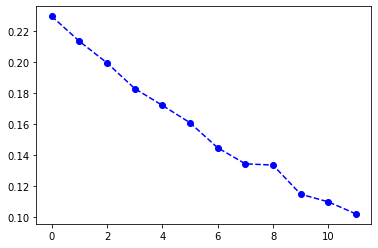

In [20]:
plt.plot(histories['train_loss'],'bo--')

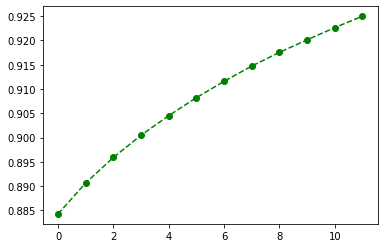

In [21]:
plt.plot(histories['train_acc'],'go--')

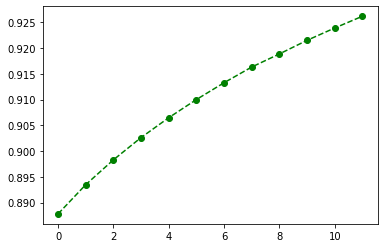

In [22]:
plt.plot(histories['val_acc'],'go--')

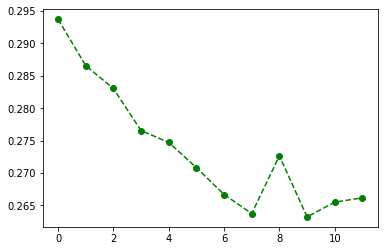

In [23]:
plt.plot(histories['eval_loss'],'go--')

### Three Test Runs

In [26]:
## Test Data
is_train = False
acc = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean('test_loss')
acc_test = tf.keras.metrics.Mean('acc_test')

def loss_fn(images, target, training):
    """ Defines the loss function        
    """
    preds = model.predict(images, training)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
    return loss


def compute_accuracy_2(images, targets,is_train):
    """ Compute the accuracy on the input data.
    """
    with tf.device(device):
        
        # Predict the probability of each class
        logits = model.predict(images, is_train)
        # Select the class with the highest probability
        
        logits = tf.nn.softmax(logits)
        logits = tf.reshape(logits, [-1, 10])
        targets = tf.reshape(targets, [-1,10])
        preds = tf.argmax(logits, axis=1)
        goal = tf.argmax(targets, axis=1)
        acc.update_state(goal, preds)
        # Compute the accuracy
        result = acc.result().numpy()
    return result

In [27]:
# Compute the loss and accuracy over testing dataset
for step, (images, target) in enumerate(test_dataset):
    loss = loss_fn(images, target, is_train)
    accuracy = compute_accuracy_2(images,target,is_train)
    acc_test(accuracy)
    test_loss(loss)
l = test_loss.result().numpy()
a = acc_test.result().numpy()
print('\nTest Accuracy: {:.2f}'.format(a))
print('Test loss: {:.4f}'.format(l))


Test Accuracy: 0.90
Test loss: 0.2699


In [48]:
## Test Data
is_train = False
acc = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean('test_loss')
acc_test = tf.keras.metrics.Mean('acc_test')

def loss_fn(images, target, training):
    """ Defines the loss function        
    """
    preds = model.predict(images, training)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
    return loss


def compute_accuracy_2(images, targets,is_train):
    """ Compute the accuracy on the input data.
    """
    with tf.device(device):
        
        # Predict the probability of each class
        logits = model.predict(images, is_train)
        # Select the class with the highest probability
        
        logits = tf.nn.softmax(logits)
        logits = tf.reshape(logits, [-1, 10])
        targets = tf.reshape(targets, [-1,10])
        preds = tf.argmax(logits, axis=1)
        goal = tf.argmax(targets, axis=1)
        acc.update_state(goal, preds)
        # Compute the accuracy
        result = acc.result().numpy()
    return result

In [49]:
# Compute the loss and accuracy over testing dataset
for step, (images, target) in enumerate(test_dataset):
    loss = loss_fn(images, target, is_train)
    accuracy = compute_accuracy_2(images,target,is_train)
    acc_test(accuracy)
    test_loss(loss)
l = test_loss.result().numpy()
a = acc_test.result().numpy()
print('\nTest Accuracy: {:.2f}'.format(a))
print('Test loss: {:.4f}'.format(l))


Test Accuracy: 0.90
Test loss: 0.2820


In [57]:
## Test Data
is_train = False
acc = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean('test_loss')
acc_test = tf.keras.metrics.Mean('acc_test')

def loss_fn(images, target, training):
    """ Defines the loss function        
    """
    preds = model.predict(images, training)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
    return loss


def compute_accuracy_2(images, targets,is_train):
    """ Compute the accuracy on the input data.
    """
    with tf.device(device):
        
        # Predict the probability of each class
        logits = model.predict(images, is_train)
        # Select the class with the highest probability
        
        logits = tf.nn.softmax(logits)
        logits = tf.reshape(logits, [-1, 10])
        targets = tf.reshape(targets, [-1,10])
        preds = tf.argmax(logits, axis=1)
        goal = tf.argmax(targets, axis=1)
        acc.update_state(goal, preds)
        # Compute the accuracy
        result = acc.result().numpy()
    return result

In [58]:
# Compute the loss and accuracy over testing dataset
for step, (images, target) in enumerate(test_dataset):
    loss = loss_fn(images, target, is_train)
    accuracy = compute_accuracy_2(images,target,is_train)
    acc_test(accuracy)
    test_loss(loss)
l = test_loss.result().numpy()
a = acc_test.result().numpy()
print('\nTest Accuracy: {:.2f}'.format(a))
print('Test loss: {:.4f}'.format(l))


Test Accuracy: 0.90
Test loss: 0.2905


# Post-activation CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [59]:
from keras.layers import Layer
import tensorflow as tf

class CustomBatchNorm(Layer):
    def __init__(self):
        super(CustomBatchNorm, self).__init__()

        self.eps=1e-5

    def build(self, input_shape):
        self.beta = self.add_weight(
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False)

        self.moving_variance = self.add_weight(
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False)

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            # assert len(inputs.shape) in (2, 4)
            # if len(inputs.shape) > 2:
            #     axes = [0, 1, 2]
            # else:
            #     axes = [0]
            # mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            
            axes = list(range(len(inputs.shape) - 1))
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True)
            batch_variance = tf.reduce_mean(tf.math.squared_difference(inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            mean = tf.squeeze(batch_mean, axes)
            var = tf.squeeze(batch_variance, axes)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
            
        inv = tf.cast(tf.math.rsqrt(var + self.eps), inputs.dtype)
        # Scale and shift
        inv *= self.gamma
        Y = inputs * inv + (self.beta - mean * inv)
        return Y

In [60]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = '/content/models_checkpoints/fmnist'
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
                         


        """
        # print(images.shape)
        x = self.conv1(images) # (128, 28, 28, 1)(batch,28,28,1) ->(128, 28, 28, 64)<class 'tensorflow.python.framework.ops.EagerTensor'>

        
        x = tf.nn.relu(x)
        x=CustomBatchNorm()(x,training=training)
        x = self.pool1(x)
        x = self.conv2(x)
        
        x = tf.nn.relu(x)
        x=CustomBatchNorm()(x,training=training)
        x = self.pool1(x)
        x = self.conv3(x)
        
        x = tf.nn.relu(x)
        x=CustomBatchNorm()(x,training=training)
        x = self.pool1(x)
        x = self.conv4(x)
        
        x = tf.nn.relu(x)
        x=CustomBatchNorm()(x,training=training)
        x = self.pool1(x)
        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets,is_train):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, is_train)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

        



    def fit_fc(self, training_data, eval_data, optimizer,is_train, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999

        training = is_train
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, is_train)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, is_train)
                    accuracy = self.compute_accuracy_2(images,target,is_train)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, is_train)
                    accuracy = self.compute_accuracy_2(images,target,is_train)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

        # self.save_model()

        # return self.history

### Three Train Runs

In [66]:
# Specify the path where you want to save/restore the trained variables.
!mkdir /content/models_checkpoints/
!mkdir /content/models_checkpoints/fmnist

checkpoint_directory = '/content/models_checkpoints/fmnist'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device,checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

mkdir: cannot create directory ‘/content/models_checkpoints/’: File exists
mkdir: cannot create directory ‘/content/models_checkpoints/fmnist’: File exists


In [67]:
# Train model Best
is_train = True
model.fit_fc(train_dataset, test_dataset, optimizer, is_train,num_epochs=20,early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  0.40361848
Train Acc at epoch 1:  0.8563433
Eval loss at epoch 1:  0.45763808
Eval Acc at epoch 1:  0.85689247
Train loss at epoch 2:  0.31735635
Train Acc at epoch 2:  0.86357045
Eval loss at epoch 2:  0.38922626
Eval Acc at epoch 2:  0.8698573
Train loss at epoch 4:  0.24314843
Train Acc at epoch 4:  0.88256556
Eval loss at epoch 4:  0.3484836
Eval Acc at epoch 4:  0.88621646
Train loss at epoch 6:  0.19507232
Train Acc at epoch 6:  0.89462095
Eval loss at epoch 6:  0.33084756
Eval Acc at epoch 6:  0.8973586
Train loss at epoch 8:  0.15192986
Train Acc at epoch 8:  0.9045842
Eval loss at epoch 8:  0.32633013
Eval Acc at epoch 8:  0.9069496


In [62]:
# Specify the path where you want to save/restore the trained variables.
!mkdir /content/models_checkpoints/
!mkdir /content/models_checkpoints/fmnist

checkpoint_directory = '/content/models_checkpoints/fmnist'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device,checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

mkdir: cannot create directory ‘/content/models_checkpoints/’: File exists
mkdir: cannot create directory ‘/content/models_checkpoints/fmnist’: File exists


In [63]:
# Train model Best
is_train = True
model.fit_fc(train_dataset, test_dataset, optimizer, is_train,num_epochs=20,early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  0.3895354
Train Acc at epoch 1:  0.8570453
Eval loss at epoch 1:  0.44856802
Eval Acc at epoch 1:  0.8592224
Train loss at epoch 2:  0.30332243
Train Acc at epoch 2:  0.8654205
Eval loss at epoch 2:  0.38006198
Eval Acc at epoch 2:  0.8723777
Train loss at epoch 4:  0.22784726
Train Acc at epoch 4:  0.8861757
Eval loss at epoch 4:  0.32934362
Eval Acc at epoch 4:  0.89021367
Train loss at epoch 6:  0.18262735
Train Acc at epoch 6:  0.89896595
Eval loss at epoch 6:  0.3136128
Eval Acc at epoch 6:  0.90181035
Train loss at epoch 8:  0.14989333
Train Acc at epoch 8:  0.90823233
Eval loss at epoch 8:  0.3158323
Eval Acc at epoch 8:  0.91044664


In [72]:
# Specify the path where you want to save/restore the trained variables.
!mkdir /content/models_checkpoints/
!mkdir /content/models_checkpoints/fmnist

checkpoint_directory = '/content/models_checkpoints/fmnist'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device,checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

mkdir: cannot create directory ‘/content/models_checkpoints/’: File exists
mkdir: cannot create directory ‘/content/models_checkpoints/fmnist’: File exists


In [73]:
# Train model Best
is_train = True
model.fit_fc(train_dataset, test_dataset, optimizer, is_train,num_epochs=20,early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  0.4109569
Train Acc at epoch 1:  0.8520833
Eval loss at epoch 1:  0.45860255
Eval Acc at epoch 1:  0.85386187
Train loss at epoch 2:  0.32258222
Train Acc at epoch 2:  0.86047745
Eval loss at epoch 2:  0.38613063
Eval Acc at epoch 2:  0.86729133
Train loss at epoch 4:  0.24881124
Train Acc at epoch 4:  0.88120514
Eval loss at epoch 4:  0.34256154
Eval Acc at epoch 4:  0.88486314
Train loss at epoch 6:  0.19126697
Train Acc at epoch 6:  0.89433753
Eval loss at epoch 6:  0.31611085
Eval Acc at epoch 6:  0.8972276
Train loss at epoch 8:  0.15491693
Train Acc at epoch 8:  0.90432507
Eval loss at epoch 8:  0.3141275
Eval Acc at epoch 8:  0.9066254
Train loss at epoch 10:  0.12733746
Train Acc at epoch 10:  0.9123902
Eval loss at epoch 10:  0.3242094
Eval Acc at epoch 10:  0.9142121


### Plot and Test

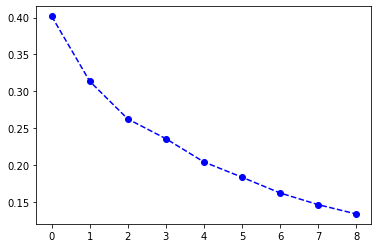

In [ ]:
plt.plot(model.history['train_loss'],'bo--')

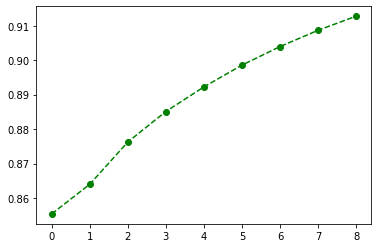

In [ ]:
plt.plot(model.history['train_acc'],'go--')

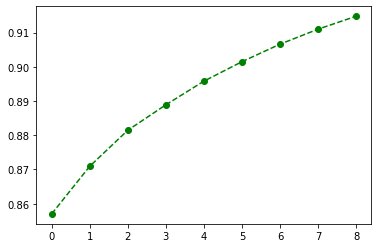

In [ ]:
plt.plot(model.history['val_acc'],'go--')

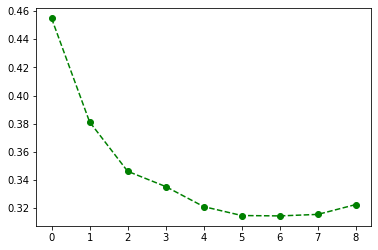

In [ ]:
plt.plot(model.history['eval_loss'],'go--')

### Three Test Runs

In [64]:
## Test Data
is_train = True
acc = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean('test_loss')
acc_test = tf.keras.metrics.Mean('acc_test')

def loss_fn(images, target, training):
    """ Defines the loss function        
    """
    preds = model.predict(images, training)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
    return loss


def compute_accuracy_2(images, targets,is_train):
    """ Compute the accuracy on the input data.
    """
    with tf.device(device):
        
        # Predict the probability of each class
        logits = model.predict(images, is_train)
        # Select the class with the highest probability
        
        logits = tf.nn.softmax(logits)
        logits = tf.reshape(logits, [-1, 10])
        targets = tf.reshape(targets, [-1,10])
        preds = tf.argmax(logits, axis=1)
        goal = tf.argmax(targets, axis=1)
        acc.update_state(goal, preds)
        # Compute the accuracy
        result = acc.result().numpy()
    return result

In [65]:
# Compute the loss and accuracy over testing dataset
for step, (images, target) in enumerate(test_dataset):
    loss = loss_fn(images, target, is_train)
    accuracy = compute_accuracy_2(images,target,is_train)
    acc_test(accuracy)
    test_loss(loss)
l = test_loss.result().numpy()
a = acc_test.result().numpy()
print('\nTest Accuracy: {:.2f}'.format(a))
print('Test loss: {:.4f}'.format(l))


Test Accuracy: 0.89
Test loss: 0.3158


In [70]:
## Test Data
is_train = False
acc = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean('test_loss')
acc_test = tf.keras.metrics.Mean('acc_test')

def loss_fn(images, target, training):
    """ Defines the loss function        
    """
    preds = model.predict(images, training)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
    return loss


def compute_accuracy_2(images, targets,is_train):
    """ Compute the accuracy on the input data.
    """
    with tf.device(device):
        
        # Predict the probability of each class
        logits = model.predict(images, is_train)
        # Select the class with the highest probability
        
        logits = tf.nn.softmax(logits)
        logits = tf.reshape(logits, [-1, 10])
        targets = tf.reshape(targets, [-1,10])
        preds = tf.argmax(logits, axis=1)
        goal = tf.argmax(targets, axis=1)
        acc.update_state(goal, preds)
        # Compute the accuracy
        result = acc.result().numpy()
    return result

In [71]:
# Compute the loss and accuracy over testing dataset
for step, (images, target) in enumerate(test_dataset):
    loss = loss_fn(images, target, is_train)
    accuracy = compute_accuracy_2(images,target,is_train)
    acc_test(accuracy)
    test_loss(loss)
l = test_loss.result().numpy()
a = acc_test.result().numpy()
print('\nTest Accuracy: {:.2f}'.format(a))
print('Test loss: {:.4f}'.format(l))


Test Accuracy: 0.89
Test loss: 0.3287


In [74]:
## Test Data
is_train = False
acc = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean('test_loss')
acc_test = tf.keras.metrics.Mean('acc_test')

def loss_fn(images, target, training):
    """ Defines the loss function        
    """
    preds = model.predict(images, training)
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
    return loss


def compute_accuracy_2(images, targets,is_train):
    """ Compute the accuracy on the input data.
    """
    with tf.device(device):
        
        # Predict the probability of each class
        logits = model.predict(images, is_train)
        # Select the class with the highest probability
        
        logits = tf.nn.softmax(logits)
        logits = tf.reshape(logits, [-1, 10])
        targets = tf.reshape(targets, [-1,10])
        preds = tf.argmax(logits, axis=1)
        goal = tf.argmax(targets, axis=1)
        acc.update_state(goal, preds)
        # Compute the accuracy
        result = acc.result().numpy()
    return result

In [75]:
# Compute the loss and accuracy over testing dataset
for step, (images, target) in enumerate(test_dataset):
    loss = loss_fn(images, target, is_train)
    accuracy = compute_accuracy_2(images,target,is_train)
    acc_test(accuracy)
    test_loss(loss)
l = test_loss.result().numpy()
a = acc_test.result().numpy()
print('\nTest Accuracy: {:.2f}'.format(a))
print('Test loss: {:.4f}'.format(l))


Test Accuracy: 0.89
Test loss: 0.3242
